# Rydberg atoms: generating highly-entangled states in large atomic arrays
**Generating high-fidelity GHZ states using Q-CTRL pulses**

BOULDER OPAL enables you to optimize controls to achieve target states in your Rydberg atomic system. In this Application note, you'll learn to optimize the generation of GHZ states for an array of multiple atoms initially in the ground state. This notebook adopts an integration method using sparse Hamiltonians and [Krylov subspaces](https://en.wikipedia.org/wiki/Krylov_subspace) to deal with the exponentially increasing memory requirements to simulate and optimize the pulses as the number of atoms in the system increases.

## Imports and initialization

In [1]:
import json
import time

import jsonpickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

In [2]:
# Helper functions
def create_initial_state(qubit_count):
    """Create initial state."""

    initial_state = np.zeros([2 ** qubit_count])
    initial_state[0] = 1.0
    return initial_state


def create_target_state(qubit_count):
    """Create target state."""

    # indices of states |0101...> and |10101...>
    idx_even = sum([2 ** n for n in range(0, qubit_count, 2)])
    idx_odd = sum([2 ** n for n in range(1, qubit_count, 2)])

    target_state = np.zeros([2 ** qubit_count])
    target_state[[idx_even, idx_odd]] = 1.0 / np.sqrt(2.0)
    return target_state


def get_durations(segments):
    """Get control segment durations."""

    return [duration / segments] * segments


def get_recommended_k(qubit_count, segment_count):
    """
    Return the appropriate Krylov subspace dimension (k) for a given set of parameters, as
    required for the integration. This is obtained for the Hamiltonian with the largest spectral range.
    """

    # Calculate terms and put together the full Hamiltonian, get first value
    H_omega, H_delta, H_fixed = get_rydberg_hamiltonian_terms(qubit_count)

    with qctrl.create_graph() as graph:
        maximal_range_hamiltonian = (
            omega_max * H_omega - delta_range * H_delta + H_fixed
        ).tocoo()

        # Calculate spectral range
        spectral_range = qctrl.operations.spectral_range(
            operator=maximal_range_hamiltonian
        )

        # Calculate the appropriate Krylov subspace dimension k
        qctrl.operations.estimated_krylov_subspace_dimension(
            spectral_range=spectral_range,
            error_tolerance=1e-6,
            duration=duration,
            maximum_segment_duration=duration / segment_count,
            name="k",
        )

    result = qctrl.functions.calculate_graph(graph=graph, output_node_names=["k"])

    return result.output["k"]["value"]


def load_var(file_name):
    """Return a variable from a json file."""

    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded

## Generating GHZ states using Q-CTRL pulses

Here you'll learn to set up and optimize controls to prepare GHZ states for different numbers of atoms.

### Characterizing the dynamics of the Rydberg system

Consider a chain of $N$ atoms, each one modeled as a qubit, with $|0\rangle$ representing the ground state and $|1\rangle$ representing a Rydberg state.
The total Hamiltonian of the system, as described by [A. Omran et al.](https://science.sciencemag.org/content/365/6453/570), is given by

$$ H = \frac{\Omega(t)}{2} \sum_{i=1}^N \sigma_x^{(i)} - \sum_{i=1}^N (\Delta(t) +\delta_i) n_i + \sum_{i<j}^N \frac{V}{\vert i-j \vert^6}n_i n_j , $$

with $\sigma_x^{(i)} = \vert 0 \rangle \langle 1 \vert_i + \vert 1 \rangle \langle 0 \vert_i$, and $n_i = \vert 1\rangle\langle 1 \vert_i$.

The fixed system parameters are the interaction strength between excited atoms, $V= 2\pi \times 24$ MHz, and the local energy shifts $\delta_i$,

$$
\delta_i =  2 \pi \times
\begin{cases}
- 4.5 \ \mathrm{MHz} \quad \mathrm{for} \ i=1,N \\
0 \quad \mathrm{otherwise}
\end{cases} \qquad \mathrm{for} \ N \leq 8 ,
\\
\delta_i =  2 \pi \times \begin{cases}
- 6.0 \ \mathrm{MHz} \quad \mathrm{for} \ i=1,N \\
- 1.5 \ \mathrm{MHz} \quad \mathrm{for} \ i=4,N-3 \\
0 \quad \mathrm{otherwise}
\end{cases} \qquad \mathrm{for} \ N > 8 .
$$

The control parameters are the effective coupling strength to the Rydberg state and the detuning, $\Omega(t)$ and $\Delta(t)$ respectively. These can be manipulated during the system evolution, which is specified to take place over a total time $T = 1.1$ µs. For convenience, the Hamiltonian terms can be grouped as follows:

$$ H = \Omega(t) h_\Omega + \Delta(t) h_\Delta + H_{\rm fixed} $$

with

$$
h_\Omega = \frac{1}{2}\sum_{i=1}^N \sigma_x^{(i)}
\qquad
h_\Delta = - \sum_{i=1}^N n_i
\qquad
H_{\rm fixed} = \sum_{i<j}^N \frac{V}{\vert i-j \vert^6}n_i n_j - \sum_{i=1}^N \delta_i n_i .
$$

In the following cell the system parameters are specified, along with a function that implements these Hamiltonian terms.

In [3]:
# Total time for the evolution
duration = 1.1e-6  # s

# Interaction strength
interaction_strength = 24.0e6 * (2 * np.pi)  # Hz

# Individual light shift for each qubit
def get_local_shifts(qubit_count):
    local_shifts = np.zeros((qubit_count,))
    if qubit_count <= 8:
        local_shifts[0] = -4.5e6 * (2.0 * np.pi)  # Hz
        local_shifts[-1] = -4.5e6 * (2.0 * np.pi)  # Hz
    else:
        local_shifts[0] = -6.0e6 * (2.0 * np.pi)  # Hz
        local_shifts[3] = -1.5e6 * (2.0 * np.pi)  # Hz
        local_shifts[-4] = -1.5e6 * (2.0 * np.pi)  # Hz
        local_shifts[-1] = -6.0e6 * (2.0 * np.pi)  # Hz
    return local_shifts


# Function to generate the Hamiltonian terms as sparse matrices
def get_rydberg_hamiltonian_terms(qubit_count):

    local_shifts = get_local_shifts(qubit_count)

    h_omega_values = []
    h_omega_indices = []
    h_delta_values = []
    h_delta_indices = []
    h_fixed_values = []
    h_fixed_indices = []

    # For each computational basis state
    for j in range(2 ** qubit_count):
        # Get binary representation
        s = np.binary_repr(j, width=qubit_count)
        state = np.array([int(m) for m in s])

        # Global shift term (big delta)
        n_exc = np.sum(state)  # Number of excited states
        h_delta_values.append(-n_exc)
        h_delta_indices.append([j, j])

        # Omega term
        for i in range(qubit_count):
            # Couple "state" and "state with qubit i flipped"
            state_p = state.copy()
            state_p[i] = 1 - state_p[i]
            h_omega_values.append(0.5)
            h_omega_indices.append([j, state_p.dot(2 ** np.arange(qubit_count)[::-1])])

        # Local shift term (small deltas)
        h_fixed = -np.sum(local_shifts * state)

        # Interaction term
        for d in range(1, qubit_count):
            # number of excited qubits at distance d
            n_d = np.dot(((state[:-d] - state[d:]) == 0), state[:-d])
            h_fixed += interaction_strength * n_d / d ** 6

        if h_fixed != 0.0:
            h_fixed_values.append(h_fixed)
            h_fixed_indices.append([j, j])

    H_omega = scipy.sparse.coo_matrix(
        (h_omega_values, np.array(h_omega_indices).T),
        shape=[2 ** qubit_count, 2 ** qubit_count],
    )

    H_delta = scipy.sparse.coo_matrix(
        (h_delta_values, np.array(h_delta_indices).T),
        shape=[2 ** qubit_count, 2 ** qubit_count],
    )

    H_fixed = scipy.sparse.coo_matrix(
        (h_fixed_values, np.array(h_fixed_indices).T),
        shape=[2 ** qubit_count, 2 ** qubit_count],
    )

    return H_omega, H_delta, H_fixed

### Optimizing Q-CTRL pulses for a system with 6 atoms

Using the Hamiltonian described in the previous section, you can now proceed with the pulse optimization. With the system initially in its ground state,

$$ |\psi(t=0)\rangle = |0000\ldots 0\rangle , $$

the optimization seeks to maximize the fidelity:

$$ {\mathcal F} = \Big|\langle \psi_\mathrm{target}|\psi(t=T)\rangle\Big|^2 , $$

which is determined by the final occupation of the target state

$$ |\psi_\mathrm{target}\rangle = \frac{1}{\sqrt{2}} \Big( |0101\ldots 1\rangle + |1010\ldots 0\rangle \Big) . $$

In order to parametrize the optimization, the controls $\Omega (t)$ and $\Delta (t)$ are specified to be piecewise constant functions: they take constant values over segments with equal durations. The optimization is defined in the following cell. This procedure involves specifying the control variables, calculating the full Hamiltonian for the system, and calculating the resulting infidelity of the process.

In [4]:
# Constraints for the control variables
omega_max = 5.0e6 * (2.0 * np.pi)  # Hz
delta_range = 15.0e6 * (2.0 * np.pi)  # Hz


def optimize_GHZ_state(
    qubit_count=6,
    segment_count=40,
    krylov_subspace_dimension=None,
    optimization_count=1,
):

    # Time the execution of the optimization
    start_time = time.time()

    # Estimate Krylov subspace dimension
    if krylov_subspace_dimension is None:
        krylov_subspace_dimension = get_recommended_k(
            qubit_count=qubit_count,
            segment_count=segment_count,
        )

    # Print parameters
    print("\n Running optimization with:")
    print("\t{} qubits".format(qubit_count))
    print("\t{} segments".format(segment_count))
    print("\tsubspace dimension {}".format(krylov_subspace_dimension))
    print("\t{} optimization runs".format(optimization_count))

    with qctrl.create_graph() as graph:

        # Physical parameters
        durations = get_durations(segment_count)
        local_shifts = get_local_shifts(qubit_count)

        omega_segments = qctrl.operations.pwc_signal(
            values=qctrl.operations.bounded_optimization_variable(
                count=segment_count, lower_bound=0.0, upper_bound=omega_max
            ),
            duration=duration,
            name="omega",
        )
        delta_segments = qctrl.operations.pwc_signal(
            values=qctrl.operations.bounded_optimization_variable(
                count=segment_count, lower_bound=-delta_range, upper_bound=+delta_range
            ),
            duration=duration,
            name="delta",
        )
        fixed_segment = qctrl.operations.pwc_signal(
            values=np.array([1]),
            duration=duration,
            name="fixed",
        )

        # Calculate Hamiltonian terms
        H_omega, H_delta, H_fixed = get_rydberg_hamiltonian_terms(qubit_count)

        shift_delta = qctrl.operations.sparse_pwc_operator(
            signal=delta_segments, operator=H_delta
        )
        shift_omega = qctrl.operations.sparse_pwc_operator(
            signal=omega_segments, operator=H_omega
        )
        shift_fixed = qctrl.operations.sparse_pwc_operator(
            signal=fixed_segment, operator=H_fixed
        )

        # Create initial and target states
        initial_state = create_initial_state(qubit_count)
        target_state = create_target_state(qubit_count)

        # Evolve the initial state
        evolved_state = qctrl.operations.state_evolution_pwc(
            initial_state=initial_state,
            hamiltonian=qctrl.operations.sparse_pwc_sum(
                [shift_fixed, shift_omega, shift_delta]
            ),
            krylov_subspace_dimension=krylov_subspace_dimension,
            sample_times=None,
        )

        # Calculate infidelity
        infidelity = qctrl.operations.abs(
            1
            - qctrl.operations.abs(
                qctrl.operations.sum(
                    qctrl.operations.conjugate(target_state) * evolved_state
                )
            )
            ** 2,
            name="infidelity",
        )

    result = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=["omega", "delta"],
        graph=graph,
        optimization_count=optimization_count,
    )

    execution_time = time.time() - start_time

    # Print the execution time and best infidelity obtained
    print(f"Execution time: {execution_time:.0f} seconds")
    print(f"Infidelity reached: {result.cost:.1e}")

    # Return the optimized results
    return {
        "result": result,
        "infidelity": result.cost,
        "omega_segments": result.output["omega"],
        "delta_segments": result.output["delta"],
        "qubit_count": qubit_count,
        "segment_count": segment_count,
        "krylov_subspace_dimension": krylov_subspace_dimension,
        "optimization_count": optimization_count,
    }

The optimization can now be called in a single line for any number of atoms $N$. You can also use pre-saved optimization data by setting the flag `use_saved_data=True`. To examine the optimized pulses and their performance, consider the case of 6 atoms:

In [5]:
# Run optimization or load data
use_saved_data = True
if use_saved_data == False:
    result = optimize_GHZ_state()
else:
    result = load_var(
        "./resources/rydberg-atoms-generating-highly-entangled-states-in-large-atomic-arrays/Rydberg_6atoms_1optimization.json"
    )
    print("\n Optimization results with:")
    print("\t{} qubits".format(result["qubit_count"]))
    print("\t{} segments".format(result["segment_count"]))
    print("\t{} optimization count".format(result["optimization_count"]))
    print("Infidelity reached: {:.1e}".format(result["infidelity"]))


 Optimization results with:
	6 qubits
	40 segments
	1 optimization count
Infidelity reached: 1.6e-05


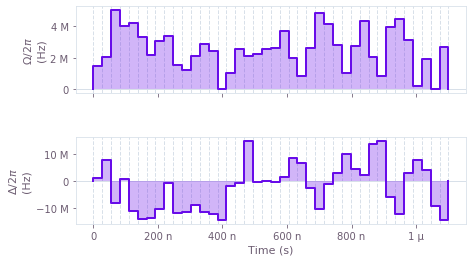

In [6]:
plot_controls(
    plt.figure(),
    {"$\Omega$": result["omega_segments"], "$\Delta$": result["delta_segments"]},
)
plt.show()

The above plots show the optimized pulses $\Omega (t)$ and $\Delta (t)$ that produce the final state.

The next cell sets up a function to plot the optimized population dynamics and the final state. This involves simulating the dynamics using the full Hamiltonian, including optimized control terms.

In [7]:
def plot_result(result):

    # Get physical parameters for the simulation
    qubit_count = result["qubit_count"]
    segment_count = result["segment_count"]
    durations = get_durations(segment_count)
    local_shifts = get_local_shifts(qubit_count)
    omega_signal = result["omega_segments"]
    delta_signal = result["delta_segments"]
    omega_segments = np.array([sig["value"] for sig in omega_signal])
    delta_segments = np.array([sig["value"] for sig in delta_signal])
    fixed_segment = np.array([1])
    krylov_subspace_dimension = result["krylov_subspace_dimension"]

    # Create initial and target states
    initial_state = create_initial_state(qubit_count)
    target_state = create_target_state(qubit_count)

    with qctrl.create_graph() as graph:
        # Calculate terms and put together the full Hamiltonian
        H_omega, H_delta, H_fixed = get_rydberg_hamiltonian_terms(qubit_count)
        hamiltonian = qctrl.operations.sparse_pwc_sum(
            [
                qctrl.operations.sparse_pwc_operator(
                    signal=qctrl.operations.tensor_pwc(
                        np.array(durations), omega_segments
                    ),
                    operator=H_omega,
                ),
                qctrl.operations.sparse_pwc_operator(
                    signal=qctrl.operations.tensor_pwc(
                        np.array(durations), delta_segments
                    ),
                    operator=H_delta,
                ),
                qctrl.operations.sparse_pwc_operator(
                    signal=qctrl.operations.tensor_pwc(
                        np.array([duration]), fixed_segment
                    ),
                    operator=H_fixed,
                ),
            ]
        )

        sample_times = np.linspace(0, duration, 200)

        # Evolve the initial state
        evolved_states = qctrl.operations.state_evolution_pwc(
            initial_state=initial_state,
            hamiltonian=hamiltonian,
            krylov_subspace_dimension=krylov_subspace_dimension,
            sample_times=sample_times,
            name="evolved_states",
        )

    states = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["evolved_states"],
    )

    # Data to plot
    idx_even = sum([2 ** n for n in range(0, qubit_count, 2)])
    idx_odd = sum([2 ** n for n in range(1, qubit_count, 2)])
    densities_t = abs(np.squeeze(states.output["evolved_states"]["value"])) ** 2
    initial_density_t = densities_t[:, 0]
    final_density_t = densities_t[:, idx_odd] + densities_t[:, idx_even]
    target_density = np.abs(target_state) ** 2

    # Style and label definitions
    plt.style.use(get_qctrl_style())
    bar_labels = [""] * 2 ** qubit_count
    bar_labels[idx_odd] = "|" + "10" * int(qubit_count / 2) + ">"
    bar_labels[idx_even] = "|" + "01" * int(qubit_count / 2) + ">"

    def bar_plot(ax, density, title):
        ax.bar(
            np.arange(2 ** qubit_count),
            density,
            edgecolor="#680CE9",
            color="#680CE94C",
            tick_label=bar_labels,
            linewidth=2,
        )
        ax.set_title(title, fontsize=14)
        ax.set_ylabel("Population", fontsize=14)
        ax.tick_params(labelsize=14)

    gs = gridspec.GridSpec(2, 2, hspace=0.3)
    fig = plt.figure()
    fig.set_figheight(2 * 5)
    fig.set_figwidth(15)
    fig.suptitle("Optimized state preparation", fontsize=16, y=0.95)

    # Plot optimized final state and target state
    ax = fig.add_subplot(gs[0, 0])
    bar_plot(ax, densities_t[-1], "Optimized final state")

    ax = fig.add_subplot(gs[0, 1])
    bar_plot(ax, target_density, "Target GHZ state")

    # Plot time evolution of basis state population
    ax = fig.add_subplot(gs[1, :])
    ax.plot(
        sample_times,
        densities_t,
        "#AAAAAA",
        linewidth=0.5,
    )
    ax.plot(
        sample_times,
        initial_density_t,
        "#FB00A5",
        linewidth=1.5,
    )
    ax.plot(
        sample_times,
        final_density_t,
        "#680CE9",
        linewidth=2,
    )
    ax.set_xticks(np.linspace(0, 1e-6, 6))
    ax.set_xticklabels(["0", "200 n", "400 n", "600 n", "800 n", "1 µ"])
    ax.tick_params(labelsize=14)
    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_ylabel("Population", fontsize=14)
    ax.set_title(
        "Basis states (gray), ground state (pink), and target state (purple)",
        fontsize=14,
    )

Your task calculate_graph has completed in 4s.


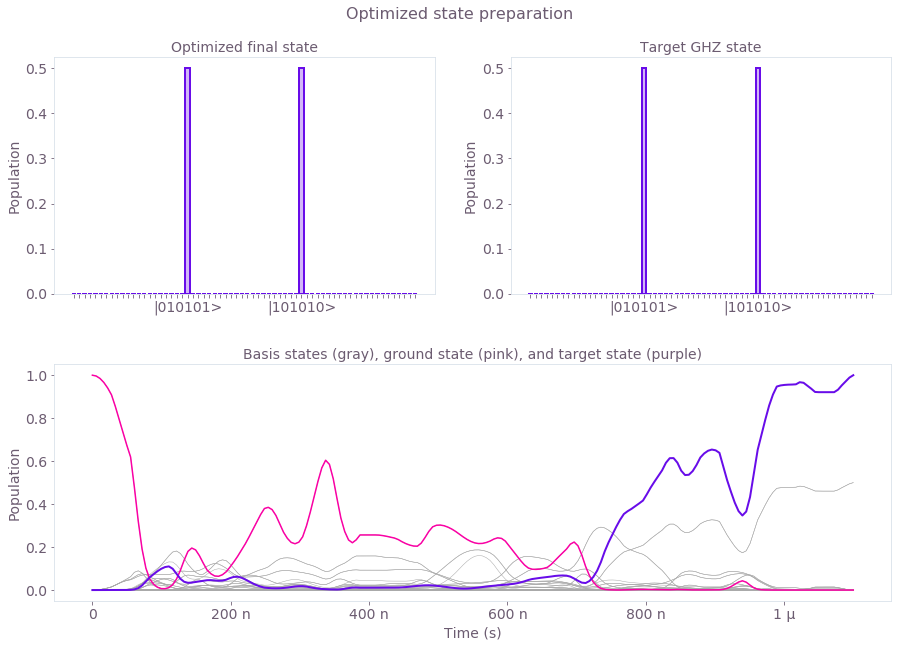

In [8]:
plot_result(result)

The plots show: (top) Final state obtained with the optimized pulses (left) and target state (right). These states are indistinguishable, with infidelity below $10^{-4}$. (bottom) Time evolution of the populations during the optimized pulse sequence, for all basis states (gray), the ground state (pink), and the target state (purple). Note that since the target GHZ state is a superposition of two basis states, these two also show in gray as having a population of 0.5 at the end of the pulse.

### Optimizing Q-CTRL pulses for up to 12 atoms

You can proceed in the same way as in the previous section to optimize the GHZ generation for different numbers of atoms.

In [9]:
# Run optimization or load data
use_saved_data = True

# List to store the results of all runs
optimization_results = []

# For different number of qubits...
for n in [4, 6, 8, 10, 12]:

    # Run or load an optimization
    if use_saved_data == False:
        result = optimize_GHZ_state(
            qubit_count=n,
            segment_count=40,
            optimization_count=3,
        )
    else:
        result = load_var(
            "./resources/rydberg-atoms-generating-highly-entangled-states-in-large-atomic-arrays/Rydberg_"
            + str(n)
            + "atoms_3optimizations.json"
        )
        print("\n Optimization results with:")
        print("\t{} qubits".format(result["qubit_count"]))
        print("\t{} segments".format(result["segment_count"]))
        print("\t{} optimization count".format(result["optimization_count"]))
        print("Infidelity reached: {:.1e}".format(result["infidelity"]))

    # Store in the list to plot below
    optimization_results.append(result)


 Optimization results with:
	4 qubits
	40 segments
	3 optimization count
Infidelity reached: 4.0e-07

 Optimization results with:
	6 qubits
	40 segments
	3 optimization count
Infidelity reached: 3.7e-05

 Optimization results with:
	8 qubits
	40 segments
	3 optimization count
Infidelity reached: 1.3e-03

 Optimization results with:
	10 qubits
	40 segments
	3 optimization count
Infidelity reached: 7.3e-03

 Optimization results with:
	12 qubits
	40 segments
	3 optimization count
Infidelity reached: 1.4e-02


Plots of the final states and populations are similar to those for $N=6$ above, so here just the final state fidelities are displayed for different atom numbers.

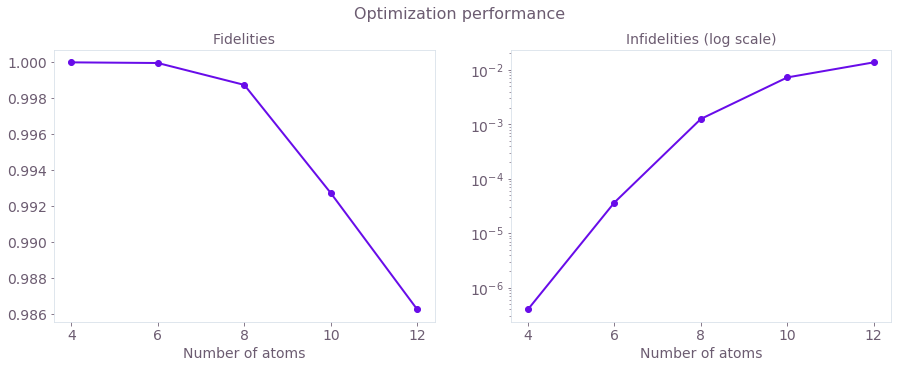

In [10]:
# Get infidelity and number of qubits of each run
infidelities = []
Nqs = []
for parameters in optimization_results:
    Nq, infid = parameters["qubit_count"], parameters["infidelity"]
    Nqs.append(Nq)
    infidelities.append(infid)
Nqs = np.array(Nqs)
infidelities = np.array(infidelities)

# Plot fidelities/infidelities vs number of qubits
gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle("Optimization performance", fontsize=16, y=1.0)

ax = fig.add_subplot(gs[0, 0])
ax.plot(Nqs, 1 - infidelities, "o-", linewidth=2)
ax.set_title("Fidelities", fontsize=14)
ax.set_xlabel("Number of atoms", fontsize=14)
ax.set_xticks([4, 6, 8, 10, 12])
ax.tick_params(labelsize=14)

ax = fig.add_subplot(gs[0, 1])
ax.semilogy(Nqs, infidelities, "o-", linewidth=2)
ax.set_title("Infidelities (log scale)", fontsize=14)
ax.set_xlabel("Number of atoms", fontsize=14)
ax.set_xticks([4, 6, 8, 10, 12])
ax.tick_params(labelsize=14)
plt.show()

The above figures display the GHZ state generation fidelities (left) and infidelities (right) achieved for different numbers of atoms. Although it is generally harder to obtain better infidelities for larger atomic arrays, using Q-CTRL optimized pulses you can obtain fidelities of over 0.99.